# Preparation

<b>Load Libraries</b>

In [12]:
# data structures
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
## settings
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme('notebook')

# models selection
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

# metrics
from sklearn.metrics import fbeta_score, make_scorer, classification_report

# pipeline
from imblearn.pipeline import Pipeline

# compose
from sklearn.compose import ColumnTransformer

# preprocessings
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# features selection
from mlxtend.feature_selection import SequentialFeatureSelector

# resamplings
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# algorithms
## linear_model
from sklearn.linear_model import LogisticRegression
## neighbors
from sklearn.neighbors import KNeighborsClassifier
## svm
from sklearn.svm import SVC
## tree
from sklearn.tree import DecisionTreeClassifier
## ensample
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# others
import re

<b>Load Dataset</b>

In [13]:
# dataset
df_base = pd.read_csv('../../../dataset/cleaned/train.csv')
df_base['area_code'] = df_base['area_code'].astype(str)

## 
num_cols = df_base.select_dtypes(np.number).columns.tolist()
cat_cols = df_base.select_dtypes('object').columns.tolist()[0:-1]

##
num_idxes = [i for i, name in enumerate(df_base.columns.tolist()) if name in num_cols]
cat_idxes = [i for i, name in enumerate(df_base.columns.tolist()) if name in cat_cols]

In [14]:
# cross validation
##
arr = df_base.values
le = LabelEncoder()

##
X, y = arr[:, :-1], le.fit_transform(arr[:, -1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

<b>User-Defined Functions</b>

In [15]:
def get_pipelines(
        encoding,
        models: list, 
        scaling: list=[], pca: list=[], resampling: list=[], 
) -> list:
    ##
    steps_num_pro = scaling + pca + resampling
    num_pro = [('num_pro', Pipeline(steps_num_pro), num_idxes)]
    cat_pro = [('cat_pro', encoding, cat_idxes)]
        
    ##
    if len(steps_num_pro) != 0:
        transformers = num_pro + cat_pro
    else:
        transformers = cat_pro
    ct = [('transform', ColumnTransformer(transformers, remainder='passthrough'))]

    ##
    pipelines = []
    for name, model in models:
        steps = ct + [(name, model)]
        pipelines.append((name, Pipeline(steps)))
        
    return pipelines

In [16]:
# parsed names:
def get_parsed_names(old_names: list, new_names: list) -> list:
    parsed_names = []

    for name in new_names:
        eles = [ele for ele in re.split('_', name) if ele != '']
        eles[1] = int(re.split('x', eles[1])[-1])

        if name != 'remainder':
            parsed_names.append(
                f'{old_names[eles[1]]}_{eles[-1]}'
            )
        else:
            parsed_names.append(f'{old_names[eles[1]]}')

    return parsed_names

In [17]:
# models
def load_base_models() -> list:
    models = []
    models.append(('LR', LogisticRegression(n_jobs=-1)))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    models.append(('SVC', SVC()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('ET', ExtraTreesClassifier(n_jobs=-1)))
    models.append(('RF', RandomForestClassifier(n_jobs=-1)))
    models.append(('GB', GradientBoostingClassifier()))
    models.append(('LGBM', LGBMClassifier(verbose=-1, n_jobs=-1)))
    models.append(('XGB', XGBClassifier(n_jobs=-1)))

    return models 

In [18]:
# kflold result
def get_kfold_results(models: list, X: np.array, y: np.array) -> tuple[np.array, np.array]:
    ##
    names, results = [], []
    cv = RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, 
        random_state=7
    )
    scoring = make_scorer(fbeta_score, beta=2)

    ##
    for name, model in models:
        cv_results = cross_val_score(
            estimator=model, 
            X=X, y=y, 
            cv=cv, scoring=scoring
        )

        print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
        names.append(name); results.append(cv_results)

    return names, results

In [19]:
# kfold visualization
def plot_kfold_results(names: list, results: list):
    data_to_plot = dict()
    for name, result in zip(names, results):
        data_to_plot[name] = result
    
    ##
    data_to_plot = pd.DataFrame(
        data=data_to_plot
    )

    new_idxes = data_to_plot.mean(axis=0)\
        .sort_values(ascending=False)\
            .index.tolist()
    data_to_plot = data_to_plot.reindex(
        labels=new_idxes, 
        axis=1
    )

    ##
    g = sns.boxplot(
        data_to_plot, 
        fill=False, 
        showmeans=True
    )
    for i in range(3):
        g.get_xticklabels()[i].set_fontweight('bold')
        g.get_xticklabels()[i].set_color('r')

<b>User-Defined Classes</b>

# 1. Base Evaluation

In [26]:
#
## filter out warning
from warnings import simplefilter
simplefilter(action='ignore')

# base models
models = load_base_models()

## encoding
encoding = OneHotEncoder(drop='first', sparse_output=False)

## pipelines
pipelines = get_pipelines(
    models=models, 
    encoding=encoding
)

## kfold results
names, results = get_kfold_results(
    models=pipelines, 
    X=X_train, y=y_train
)

LR: 0.1140139850927701 (0.04598774724850602)
KNN: 0.338211082422177 (0.06983185178124487)
SVC: 0.0 (0.0)
CART: 0.7305763368662027 (0.040921157860294814)
ET: 0.5263655575217201 (0.08000260206870782)
RF: 0.6804776638754438 (0.06696476936972869)
GB: 0.7797942022901352 (0.04908242074689059)
LGBM: 0.800041432140695 (0.03862294674174429)
XGB: 0.8022670625552176 (0.04757979959513285)


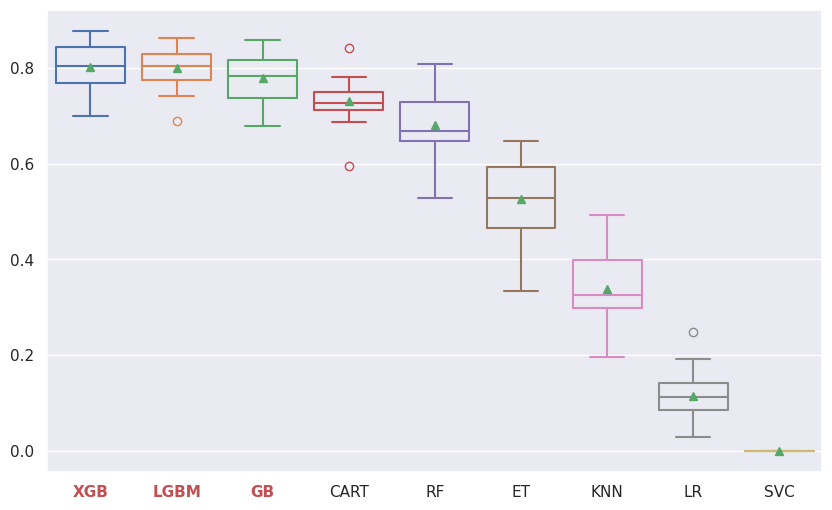

In [27]:
# visualizations
plot_kfold_results(
    names=names, results=results
)

# 2. Scaling

<b>Standardization</b>

In [23]:
#
## filter out warnings
from warnings import simplefilter
simplefilter(action='ignore')

## base models
models = load_base_models()

## encoding
encoding = OneHotEncoder(drop='first', sparse_output=False)

## scaling
scaling = [('standardize', StandardScaler())]

## pipelines
pipelines = get_pipelines(
    models=models, 
    encoding=encoding, 
    scaling=scaling
)

## kfold results
names, results = get_kfold_results(
    models=pipelines, 
    X=X_train, y=y_train
)

LR: 0.26277994255518317 (0.08258477260774924)
KNN: 0.2846232710894575 (0.052451405077512274)
SVC: 0.48484071596755907 (0.07232209739944413)
CART: 0.7362176708369315 (0.044049115264793055)
ET: 0.5431405577632751 (0.06717975182087989)
RF: 0.6855884669967764 (0.06669621309179935)
GB: 0.7778665940019346 (0.04874385276381624)
LGBM: 0.7995988188260913 (0.04233808951873371)
XGB: 0.8044442832038313 (0.043988249844242704)


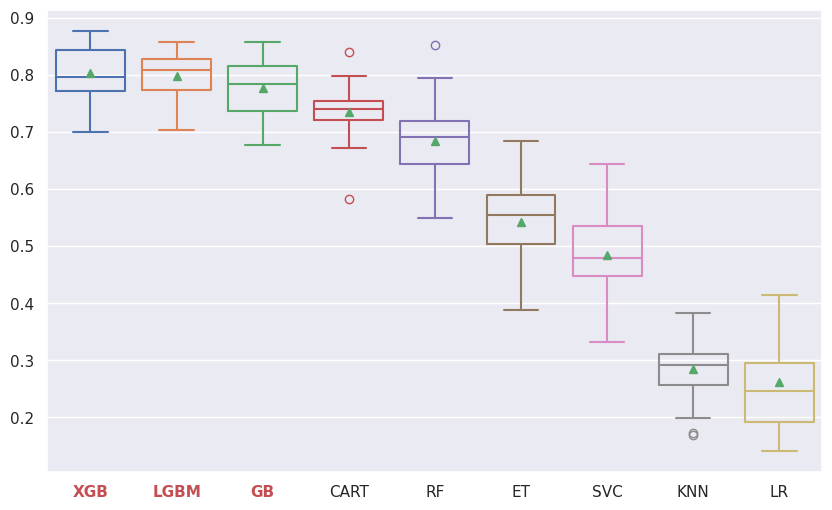

In [24]:
# visualization
plot_kfold_results(
    names=names, results=results
)

<b>Power transformation</b>

# 3.1 Feature Selection without "PCA"

<b>Sequential feature selection</b>

<b>RFE</b>

# 3.2 Feature Selection with "PCA"

<b>Sequential feature selection</b>

<b>RFE</b>

# 4. Resampling

<b>Over sampling</b>

<b>Combine</b>